In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import quantumpropagator as qp
from quantumpropagator import readWholeH5toDict, abs2
#from __future__ import print_function
from ipywidgets import interact#, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
subfolders = sorted([ dir for dir in os.listdir('.') if os.path.isdir(dir) and dir != '.ipynb_checkpoints'])
print(''.join(['{} -> {}\n'.format(a,b) for a,b in enumerate(subfolders)]))

0 -> oewExtrapolated_0000
1 -> oewExtrapolated_0001



In [3]:
interactive = True
a = subfolders[-1]
#a = subfolders[9]

In [4]:
filesList = [ fn for fn in sorted(os.listdir(a)) if fn[:8] == 'Gaussian' and fn[-3:] == '.h5']
outh5 = os.path.join(a,'allInput.h5')
dictio = readWholeH5toDict(outh5)
phis,gams,thes = dictio['phis'],dictio['gams'],dictio['thes']
# dictio.keys()
zeroWF = qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')
vmaxV = abs2(zeroWF).max()
phiL,gamL,theL,nstates = (qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')).shape
filesN = len(filesList)
allwf = np.empty((filesN,phiL,gamL,theL,nstates),dtype=complex)
alltime = np.empty((filesN))
lastV = len(filesList)-1

for i,fn in enumerate(filesList):
    fnn = os.path.join(a,fn)
    allwf[i] = qp.retrieve_hdf5_data(fnn,'WF')
    alltime[i] = qp.retrieve_hdf5_data(fnn,'Time')[0]

outfn = os.path.join(a,'output')
outfnP = os.path.join(a,'outputPopul')
data = pd.read_csv(outfn, delim_whitespace=True, header=None);
dataP = pd.read_csv(outfnP, delim_whitespace=True, header=None);
data.columns = ['count','steps','fs','Norm Deviation','Kinetic','Potential','Total','Total deviation','Xpulse','Ypulse','Zpulse']
result = pd.concat([data, dataP], axis=1);

phisT, gamsT, thesT = qp.fromFloatsToLabels(phis, gams, thes)


equi_p = phisT.index('P000-000')
equi_g = gamsT.index('P016-923')
equi_t = thesT.index('P114-804')


# 2D slices

In [5]:
def heatThisP(file_number,first,second,vmaxV,state,sliced,which,save=None):
    '''
    
    '''
    wf = allwf[i]
    time = alltime[i]
    aaa = np.rad2deg
    save = save or False
    fig = plt.figure(figsize=(10, 15), dpi= 80, facecolor='w', edgecolor='k')
    #fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
    plt.title('Time = {:10.5f} fs'.format(time))

    if which == 'phi':
        wf   = wf[sliced,:,:,state]
        plt.ylabel('Gamma')
        plt.xlabel('Theta')
        ext = [second[0],second[-1],first[0],first[-1]]
        #ext = [aaa(second[0]),aaa(second[-1]),aaa(first[0]),aaa(first[-1])]
    
    elif which == 'gam':
        wf   = wf[:,sliced,:,state]
        plt.ylabel('Phi')
        plt.xlabel('Theta')
        ext = [second[0],second[-1],first[0],first[-1]]
        #ext = [aaa(second[0]),aaa(second[-1]),first[0]*50,first[-1]*50]
        
    elif which == 'the':
        wf   = wf[:,:,sliced,state]
        plt.ylabel('Phi')
        plt.xlabel('Gamma')
        ext = [second[0],second[-1],first[0],first[-1]]
        #ext = [aaa(second[0]),aaa(second[-1]),first[0]*50,first[-1]*50]
    

    
    # this is to get a nice colorbar on the side
    ax = plt.gca()

    im = ax.imshow(qp.abs2(wf), extent=ext, cmap='hot', vmax=vmaxV)
    #im = ax.imshow(qp.abs2(wf), cmap='PuBu_r', vmax=0.4)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
    
    if save:
        fig.savefig(os.path.splitext(h5File)[0] + '.png')
        plt.close()

# Phi Slices

In [6]:
def f_tg(frame,state,phi):
    return heatThisP(frame,gams,thes,vmaxV,state,phi,'phi')

interact(f_tg, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV),state = widgets.IntSlider(min=0,max=nstates-1,step=1,value=0), phi = widgets.IntSlider(min=0,max=phiL-1,step=1,value=equi_p));
createimages = False

interactive(children=(IntSlider(value=269, description='frame', max=269), IntSlider(value=0, description='stat…

# Gamma slices

In [7]:
def f_pt(frame, state, gamma):
    return heatThisP(frame,phis,thes,vmaxV,state,gamma,'gam')

interact(f_pt, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV),state = widgets.IntSlider(min=0,max=nstates-1,step=1,value=0), gamma = widgets.IntSlider(min=0,max=gamL-1,step=1,value=equi_g));

interactive(children=(IntSlider(value=269, description='frame', max=269), IntSlider(value=0, description='stat…

# Theta slices

In [8]:
def f_pg(frame, state, theta):
    return heatThisP(os.path.join(a,filesList[frame]),phis,gams,vmaxV,state,theta,'the')

interact(f_pg, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV),state = widgets.IntSlider(min=0,max=nstates-1,step=1,value=0), theta = widgets.IntSlider(min=0,max=theL-1,step=1,value=equi_t));

interactive(children=(IntSlider(value=269, description='frame', max=269), IntSlider(value=0, description='stat…

# 1d slices DIFFERENT STATES AT DIFFERENT HIGH

In [9]:

%matplotlib notebook
def slice1D(fN, first, second, label, exa):
    fig = plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
    exa = exa*10
    wf = allwf[fN]
    time = alltime[fN]
    initialEne = result['Total'][0]
    initialEne = (np.arange(8)*2)+ initialEne
    plt.ylim(-1,15)
    if label == 'phi':
        ys = wf[:,first,second,:]
        poten_cut = qp.fromHartoEv(dictio['potCube'][:,first,second,:])
        plt.title('Time = {:10.5f} fs | gamma = {:8.3f} | theta = {:8.3f}'.format(time,gams[first],thes[second]))
        labelsX = phis
        plt.xlabel('Phi')
    if label == 'gam':
        ys = wf[first,:,second,:]
        poten_cut = qp.fromHartoEv(dictio['potCube'][first,:,second,:])
        plt.title('Time = {:10.5f} fs | phi = {:8.3f} | theta = {:8.3f}'.format(time,phis[first],thes[second]))
        labelsX = gams
        plt.xlabel('Gamma')
    if label == 'the':
        ys = wf[first,second,:,:]
        poten_cut = qp.fromHartoEv(dictio['potCube'][first,second,:,:])
        plt.title('Time = {:10.5f} fs | phi = {:8.3f} | gamma = {:8.3f}'.format(time,phis[first],gams[second]))
        labelsX = thes
        plt.xlabel('Theta')

    thres = 1e-10
    
    # np.imag of "nan" is 0.0
    
    realPart = np.real(ys)*exa + initialEne
    imagPart = np.imag(ys)*exa + initialEne
    absPart = abs2(ys)*exa*5 + initialEne
    
    realPart2 = np.where(abs2(ys)<thres,np.nan,realPart) 
    imagPart2 = np.where(abs2(ys)<thres,np.nan,imagPart) 
    absPart2 = np.where(abs2(ys)<thres,np.nan,absPart) 
    
    plt.plot(labelsX, realPart2, linewidth=1,ls='--')
    plt.plot(labelsX, imagPart2, linewidth=1,ls='--')
    plt.plot(labelsX, absPart2, linewidth=2,ls='-')
    plt.plot(labelsX, poten_cut, linewidth=1,ls='-.')

## 1D Phi

In [10]:
def fphi(file_number,gamma, theta,exa):
    return slice1D(file_number, gamma, theta, 'phi', exa)

interact(fphi, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV), gamma = widgets.IntSlider(min=0,max=gamL-1,step=1,value=equi_g), theta = widgets.IntSlider(min=0,max=theL-1,step=1,value=equi_t), exa = widgets.IntSlider(min=1,max=10,step=1,value=1));

interactive(children=(IntSlider(value=269, description='file_number', max=269), IntSlider(value=30, descriptio…

## 1D Gamma

In [11]:
def fgam(file_number,phi,theta,exa):
    return slice1D(file_number, phi, theta, 'gam', exa)

interact(fgam, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV), phi = widgets.IntSlider(min=0,max=phiL-1,step=1,value=equi_p), theta = widgets.IntSlider(min=0,max=theL-1,step=1,value=equi_t), exa = widgets.IntSlider(min=1,max=10,step=1,value=1));

interactive(children=(IntSlider(value=269, description='file_number', max=269), IntSlider(value=29, descriptio…

## 1D Theta

In [12]:
def fthe(file_number,phi,gamma,exa):
    return slice1D(file_number, phi, gamma, 'the', exa)

interact(fthe, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV), phi = widgets.IntSlider(min=0,max=phiL-1,step=1,value=equi_p), gamma = widgets.IntSlider(min=0,max=gamL-1,step=1,value=equi_g), exa = widgets.IntSlider(min=1,max=10,step=1,value=1));

interactive(children=(IntSlider(value=269, description='file_number', max=269), IntSlider(value=29, descriptio…

# Population and Energies

In [13]:
result = pd.concat([data, dataP], axis=1)
result

,count,steps,fs,Norm Deviation,Kinetic,Potential,Total,Total deviation,Xpulse,Ypulse,Zpulse,0,1,2,3,4,5,6,7,8
0,0,0,0.000000,8.881784e-16,0.094669,0.302619,0.397288,0.000000e+00,3.719408e-09,3.719408e-09,3.719408e-09,0.0000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1,100,0.100099,9.260832e-07,0.094868,0.302419,0.397287,9.178431e-07,4.264817e-09,4.264817e-09,4.264817e-09,0.1001,0.999998,7.085690e-17,1.923670e-24,3.128580e-25,8.321790e-18,3.810930e-18,7.633920e-18,2.974080e-18
2,2,200,0.200199,3.702687e-06,0.095465,0.301819,0.397284,3.669324e-06,-1.908942e-09,-1.908942e-09,-1.908942e-09,0.2002,0.999993,1.385500e-16,3.641150e-24,5.864960e-25,1.584720e-17,6.797370e-18,1.371050e-17,5.191800e-18
3,3,300,0.300298,8.324884e-06,0.096457,0.300823,0.397280,8.248314e-06,-1.728873e-08,-1.728873e-08,-1.728873e-08,0.3003,0.999983,4.849510e-16,1.613910e-23,2.725520e-24,6.958330e-17,3.760750e-17,7.549960e-17,3.021680e-17
4,4,400,0.400397,1.478449e-05,0.097838,0.299435,0.397273,1.464464e-05,-3.270009e-08,-3.270009e-08,-3.270009e-08,0.4004,0.999970,5.168040e-15,1.417300e-22,2.277310e-23,6.230380e-16,2.603180e-16,5.292970e-16,1.947890e-16
5,5,500,0.500496,2.307013e-05,0.099603,0.297662,0.397265,2.284418e-05,-2.134490e-08,-2.134490e-08,-2.134490e-08,0.5005,0.999954,1.426340e-14,3.440760e-22,5.319640e-23,1.517310e-15,5.193510e-16,1.060370e-15,3.687360e-16
6,6,600,0.600596,3.316727e-05,0.101744,0.295512,0.397255,3.282891e-05,4.710971e-08,4.710971e-08,4.710971e-08,0.6006,0.999934,1.621080e-14,4.295020e-22,6.774420e-23,1.894510e-15,7.277220e-16,1.482510e-15,5.329640e-16
7,7,700,0.700695,4.505835e-05,0.104249,0.292994,0.397244,4.457711e-05,1.610795e-07,1.610795e-07,1.610795e-07,0.7007,0.999910,9.637690e-14,2.857410e-21,4.493140e-22,1.240410e-14,5.128440e-15,1.039350e-14,3.887650e-15
8,8,800,0.800794,5.872283e-05,0.107108,0.290122,0.397230,5.806342e-05,2.137000e-07,2.137000e-07,2.137000e-07,0.8008,0.999883,4.536600e-13,1.168460e-20,1.752350e-21,4.976510e-14,1.716290e-14,3.471200e-14,1.269510e-14
9,9,900,0.900893,7.413736e-05,0.110307,0.286908,0.397215,7.325911e-05,1.788564e-08,1.788564e-08,1.788564e-08,0.9009,0.999852,7.398530e-13,1.710950e-20,2.495790e-21,7.220980e-14,2.117680e-14,4.277780e-14,1.515730e-14


<IPython.core.display.Javascript object>


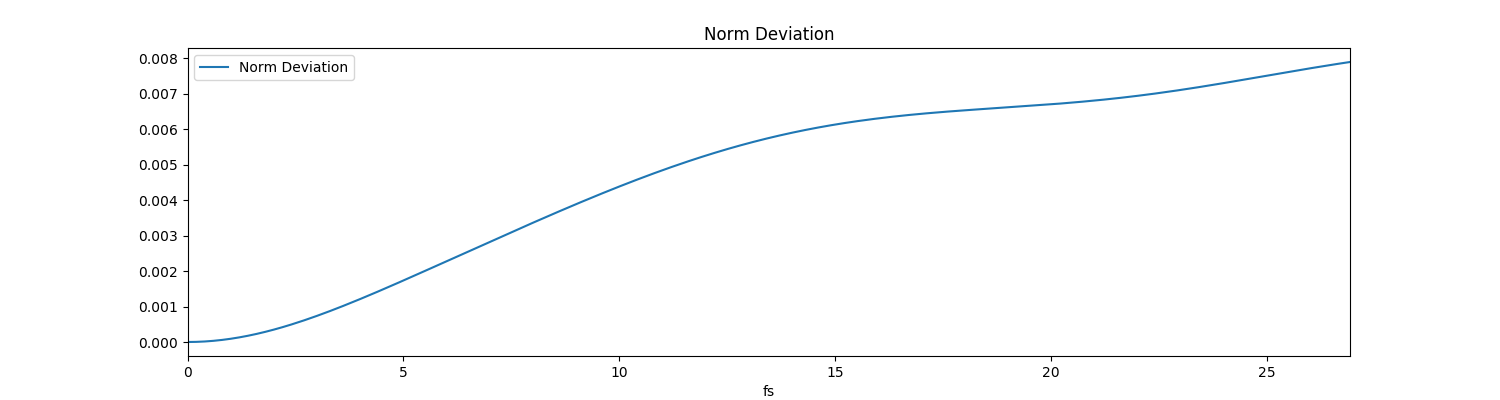

<IPython.core.display.Javascript object>


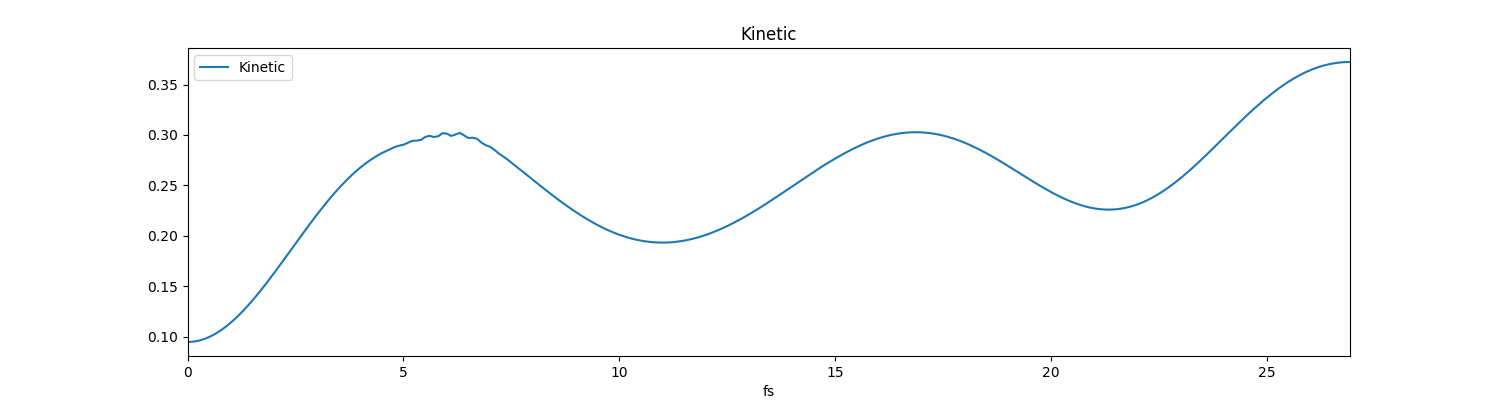

<IPython.core.display.Javascript object>


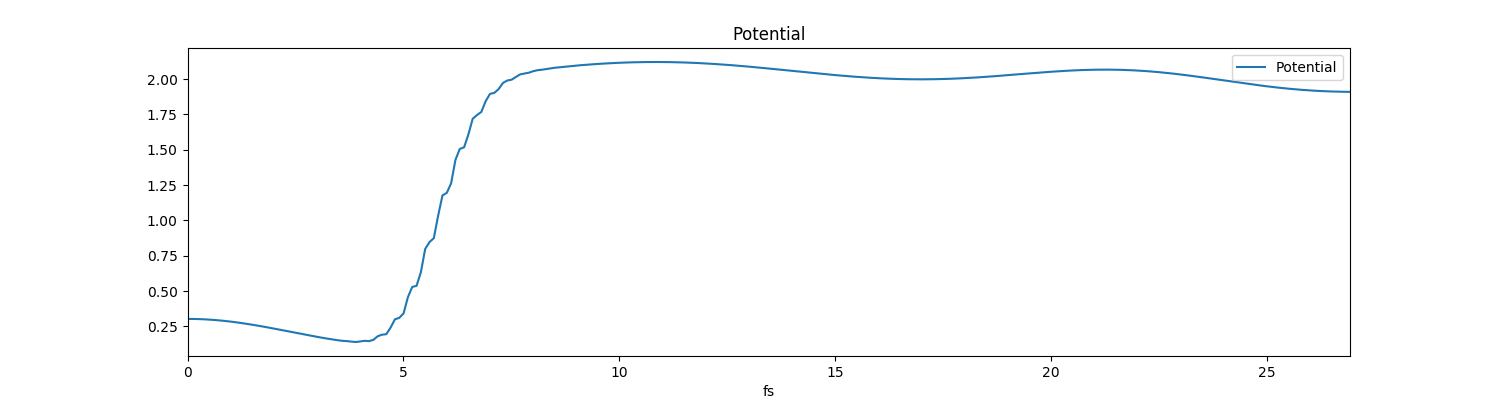

<IPython.core.display.Javascript object>


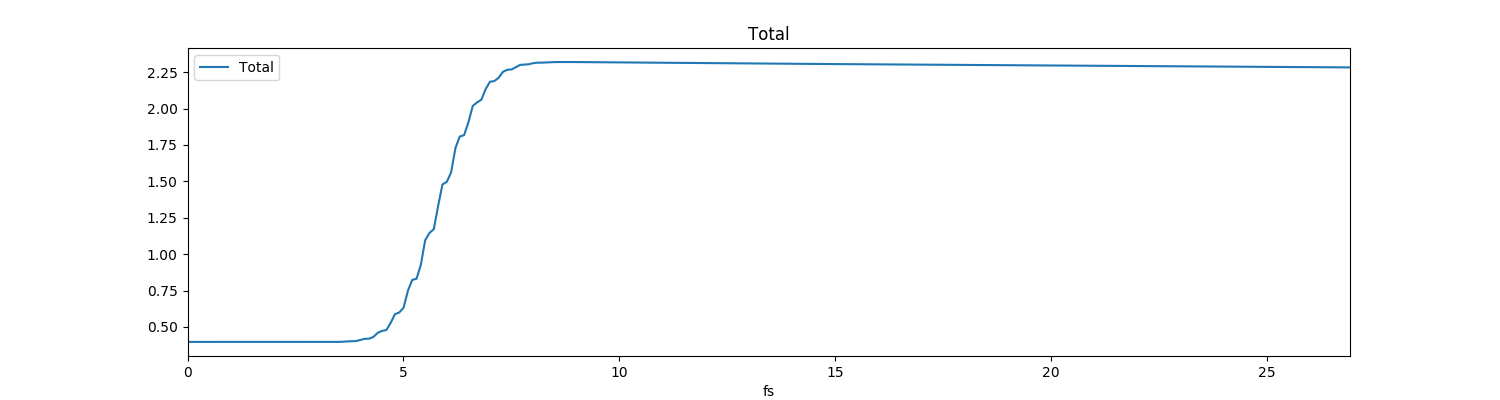

In [14]:
data.plot(title = 'Norm Deviation', x='fs', y = 'Norm Deviation', figsize=(15,4));
data.plot(title = 'Kinetic', x='fs', y = 'Kinetic', figsize=(15,4));
data.plot(title = 'Potential', x='fs', y = 'Potential', figsize=(15,4));
data.plot(title = 'Total', x='fs', y = 'Total', figsize=(15,4));

<IPython.core.display.Javascript object>


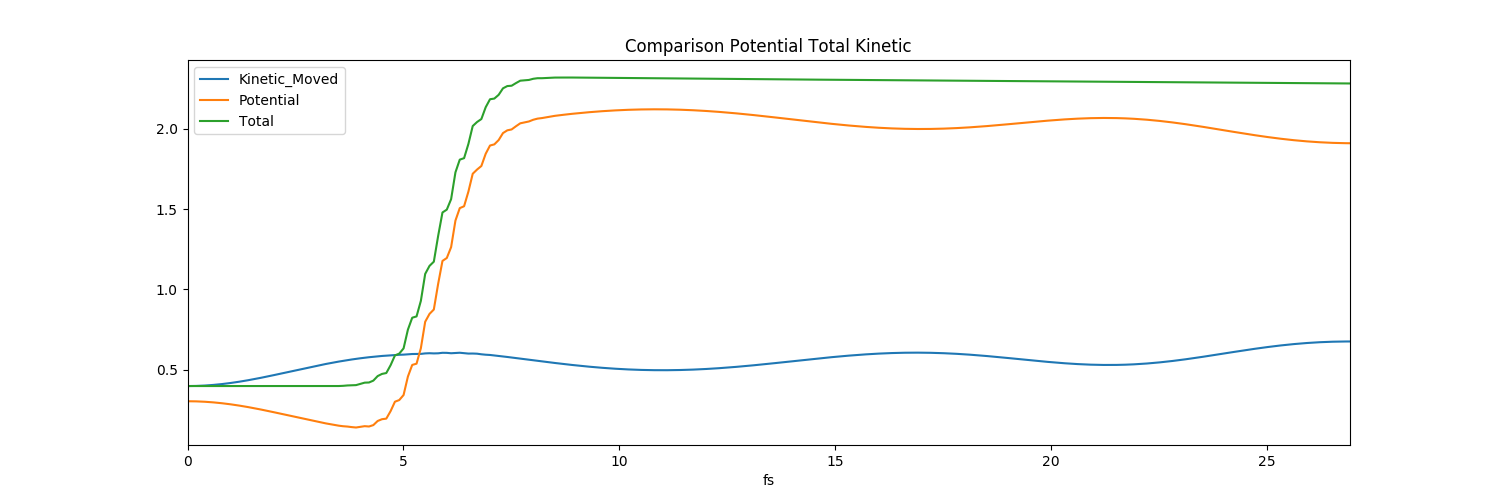

In [15]:
data['Kinetic_Moved'] = data['Kinetic'] + data['Potential'][0]
data.plot(title = 'Comparison Potential Total Kinetic', x=['fs'] ,y=['Kinetic_Moved','Potential','Total'], figsize=(15,5));

<IPython.core.display.Javascript object>


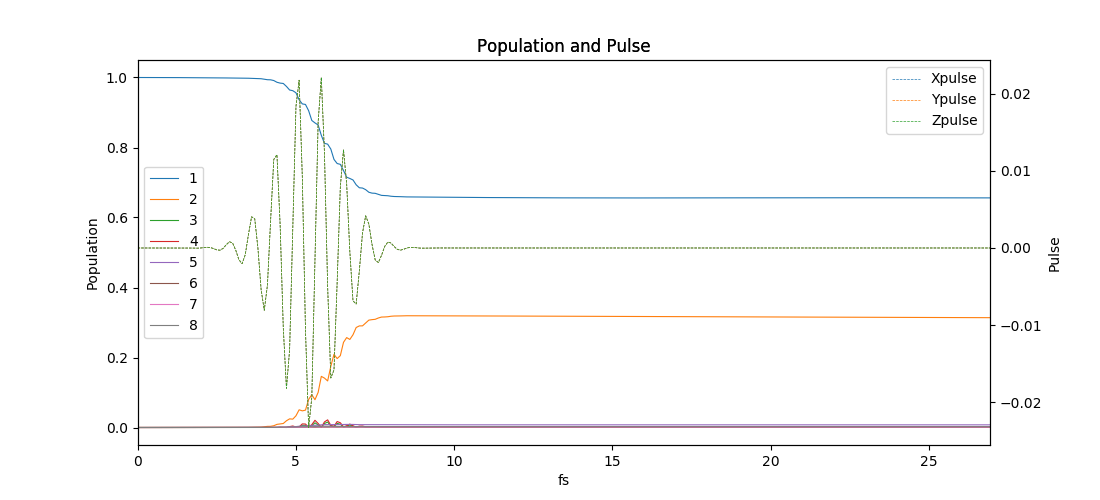

In [16]:
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.set_ylabel('Population')
ax2.set_ylabel('Pulse')
popul = np.arange(nstates)+1
result.plot(title = 'Population and Pulse', ax = ax1,  x=['fs'] ,y=popul, linewidth=0.8)
result.plot(title = 'Population and Pulse', ax = ax2,  x=['fs'] ,y=['Xpulse','Ypulse','Zpulse'], linewidth=0.5,ls='--');

## Expected values

In [17]:
def expected(fN):
    wf = allwf[fN]
    time = alltime[fN]
    print('Time: {:5.2f} fs'.format(time))
    _,_,_,nstates = wf.shape
    for i in range(nstates):
        wfState = wf[:,:,:,i]
        popu = np.linalg.norm(wfState) # this is norm, the real popu is this squared
        if popu == 0:
            print('Expected Values State {}:\nPopul: {:10.3f} \n  Phi: - \n  Theta: - \n  Gamma: -'.format(i, popu**2))
        else:
            wfA = abs2(wfState/popu)
            # We need to sun and then sum again. From 3d to 1d.
            phiAvg = np.sum(np.sum(wfA,axis=2),axis=1)
            gamAvg = np.sum(np.sum(wfA,axis=2),axis=0)
            theAvg = np.sum(np.sum(wfA,axis=1),axis=0)
            phiA = sum([ phis[i] * phiAvg[i] for i in range(phiAvg.size) ])
            gamA = sum([ gams[i] * gamAvg[i] for i in range(gamAvg.size) ])
            theA = sum([ thes[i] * theAvg[i] for i in range(theAvg.size) ])
            print('Expected Values State {}:\nPopul: {:10.3f} \n  Phi:   {:10.3f} \n  Theta: {:10.3f} \n  Gamma: {:10.3f}'.format(i, popu**2, phiA, theA, gamA))

def fexp(frame):
    return expected(frame)

if interactive:
    interact(fexp, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV));
else:
    print('First Step:')
    fexp(0)
    print('Last Step:')
    fexp(lastV)

interactive(children=(IntSlider(value=269, description='frame', max=269), Output()), _dom_classes=('widget-int…

## Look at side of cell

In [18]:
def side(fN):
    wf = allwf[fN]
    time = alltime[fN]
    print('Time: {:5.2f} fs'.format(time))
    _,_,_,nstates = wf.shape
    for i in range(nstates):
        wfAB = qp.abs2(wf[:,:,:,i])
        print('State {}:'.format(i))
        print('Phi -> {:5.2e} {:5.2e}'.format(np.sum(wfAB[-1,:,:]),np.sum(wfAB[0,:,:])))
        print('Gam -> {:5.2e} {:5.2e}'.format(np.sum(wfAB[:,-1,:]),np.sum(wfAB[:,0,:])))
        print('The -> {:5.2e} {:5.2e}\n'.format(np.sum(wfAB[:,:,-1]),np.sum(wfAB[:,:,0])))


def side_f(frame):
    return side(frame)

if interactive:
    interact(side_f, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV));
else:
    print('First Step:')
    side_f(0)
    print('Last Step:')
    side_f(lastV)   

interactive(children=(IntSlider(value=269, description='frame', max=269), Output()), _dom_classes=('widget-int…